In [1]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.optim.optimizer import Optimizer, required
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [2]:
n_epochs = 50         #number of epochs of training
batch_size = 64       #size of the batches
lr = 0.0002           #adam: learning rate
b1 = 0.5              #adam: decay of first order momentum of gradient
b2 = 0.999            #adam: decay of second order momentum of gradient
n_cpu = 8,            #number of cpu threads to use during batch generation
latent_dim = 100      #dimensionality of the latent space
img_size = 28         #size of each image dimension
channels = 1          #number of image channels
sample_interval = 400 #interval between image samples

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

random_seed = 1
torch.manual_seed(random_seed)

# Load Data

In [3]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "D:\PatternRecognition_Data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Excercise 1. Generative Adversarial Networks (GANs)
Implement a GAN and train it on the MNIST dataset 

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

## Training loop implementation

In [6]:
def train_loop(
    generator: nn.Module, 
    discriminator: nn.Module, 
    g_optim: Optimizer, 
    d_optim: Optimizer,
    latent_dim,
    max_iter=100,
    cuda=True
    ):
    if cuda:
        generator, discriminator = generator.cuda(), discriminator.cuda()
    criterion = nn.BCELoss()
    g_losses, d_losses = [], []
    for epoch in range(max_iter):
        for i, (imgs, _) in enumerate(dataloader):
            # Configure input
            real_imgs = imgs
            batch_size_internal = real_imgs.shape[0]
            # Adversarial ground truths
            # We use the Cross Entropy (CE) loss. So we need labels:
            ones_labels = torch.ones([batch_size_internal,1])
            zeros_labels = torch.zeros([batch_size_internal,1])
            # Sample noise as generator input
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_() # sample z from a standard gaussian
            if cuda:
                real_imgs = real_imgs.cuda()
                z = z.cuda()
                ones_labels, zeros_labels = ones_labels.cuda(), zeros_labels.cuda()
            
            # -----------------
            #  Train Generator
            # -----------------
            generator.train()
            discriminator.eval()
            g_optim.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)# create generated images

            # Loss measures generator's ability to fool the discriminator
            g_loss = criterion(discriminator(gen_imgs), ones_labels)

            g_loss.backward()
            g_optim.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            generator.eval()
            discriminator.train()
            d_optim.zero_grad()
            
            # Sample noise as generator input
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_() # sample z from a standard gaussian
            if cuda:
                z = z.cuda()
            gen_imgs = generator(z)
            # Measure discriminator's ability to classify real from generated samples
            real_loss = criterion(discriminator(real_imgs), ones_labels)
            fake_loss = criterion(discriminator(gen_imgs), zeros_labels)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            d_optim.step()
            
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            
            if i%50 == 0:
                  print(
                  "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %.6f] [G loss: %.6f]"
                  % (epoch+1, max_iter, i, len(dataloader), d_loss.item(), g_loss.item()), end='\r'
            )

            batches_done = epoch * len(dataloader) + i
    #         if batches_done % sample_interval == 0:
    #             # You can also safe samples in your drive & maybe save your network as well
    #             save_image(gen_imgs.data[:25], "images/GAN-%d.png" % batches_done, nrow=5, normalize=True)
    print()
    return g_losses, d_losses

## Run Training

In [7]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Optimizers
g_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
d_optim = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [86]:
g_losses, d_losses = train_loop(generator, discriminator, g_optim, d_optim, 
                                max_iter=10, latent_dim=latent_dim, cuda=True)

[Epoch 10/10] [Batch 900/938] [D loss: 0.140566] [G loss: 3.790598]


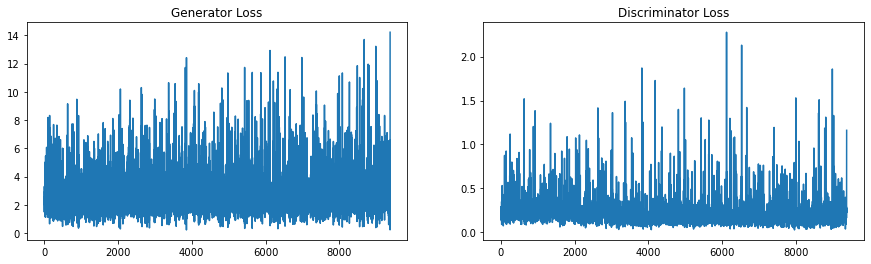

In [87]:
fig = plt.figure(figsize=(15, 4))
columns = 2
rows = 1
counter = 0
for losses, titles in zip([g_losses, d_losses],["Generator Loss", "Discriminator Loss"]):
    fig.add_subplot(rows, columns, counter+1)
    plt.plot(losses)
    plt.title(titles)
    counter += 1
plt.show()

## (a). Plot 10 samples generated using the GAN 

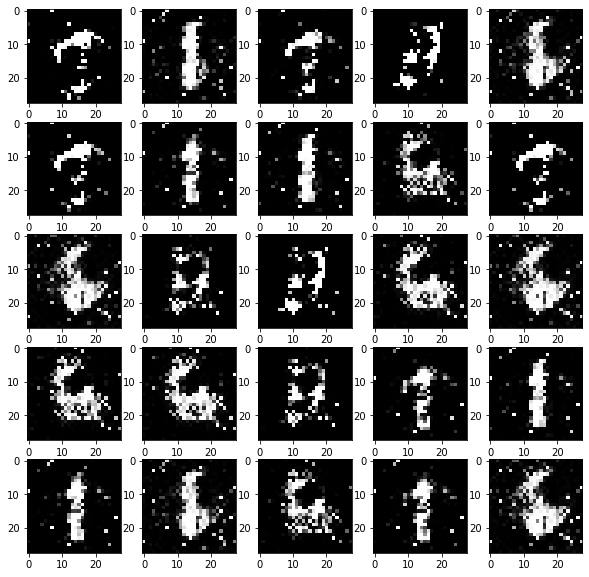

In [88]:
n = 25
z = torch.FloatTensor(n, latent_dim).normal_()
z = z.cuda()
sampled = generator(z)

fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
counter = 0
for img in sampled:
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    counter += 1
plt.show()

##  (b). Finally, train a classifier C that classifies MNIST images. Use that classifier to approximate the marginal distribution of the generator p(y), (i.e. the probability that the GAN samples a particular class). Visualize the distribution using a bar-plot

###  Step 1: Train a model on the MNIST data set

In [26]:
DataPath = r"D:\PatternRecognition_Data"

train_data = datasets.MNIST(DataPath, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 32
trainset = datasets.MNIST(root=DataPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST(root=DataPath, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
to_pil_image = transforms.ToPILImage()

In [27]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
model.cuda()
model.train()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))

Epoch 0 - Training loss: 0.3768647905319929
Epoch 1 - Training loss: 0.14763689043869574
Epoch 2 - Training loss: 0.10303786220550537
Epoch 3 - Training loss: 0.07771032790703078
Epoch 4 - Training loss: 0.06213690687225511
Epoch 5 - Training loss: 0.05039827274040629
Epoch 6 - Training loss: 0.04136361267535637
Epoch 7 - Training loss: 0.033892026108130816
Epoch 8 - Training loss: 0.027025991675940653
Epoch 9 - Training loss: 0.023284319132834207


In [28]:
 correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    tmp = images[i].cuda()
    img = tmp.view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu().detach().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9756


### Step 2: Generate x many fake MNIST samples with trained GAN

In [89]:
noise = torch.FloatTensor(100, latent_dim).normal_()
generated_imgs = generator(noise.cuda())

### Step 3: Apply C to fake MNIST set and evaluate density over predicted digits

In [90]:
GAN_labels = [] 
for im in generated_imgs:
    logps = model(im.reshape([-1,784]))
    ps = torch.exp(logps).cpu().detach()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    GAN_labels.append(pred_label)

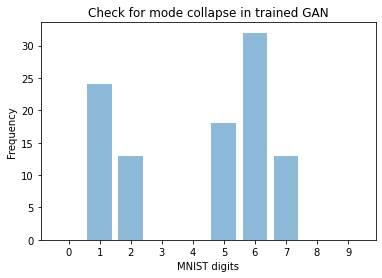

In [91]:
objects = list(range(10))
y_pos = np.arange(len(objects))
counts = [GAN_labels.count(c) for c in range(10)]

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Check for mode collapse in trained GAN')
plt.xlabel('MNIST digits')
plt.ylabel('Frequency')

plt.show()

# Wasserstein GAN
Steps: <br>
- Replace discriminator with critic with real valued output
- Objective: minimize Earth-Mover distance + Gradient Penalty between p_data and p_G(z)
- the critic is updated more often than the generator (5 times more for example)

In [21]:
def gradient_penalty_func(real_imgs, gen_imgs, discriminator, cuda):
    lambda_weight = 10
    batch_size_internal = real_imgs.shape[0]
    eps = torch.FloatTensor(batch_size_internal, real_imgs.shape[1], real_imgs.shape[2], real_imgs.shape[3]).normal_()
    if cuda:
        eps = eps.cuda()
    x_hat = eps * real_imgs + (1-eps) * gen_imgs
    x_hat = Variable(x_hat, requires_grad=True)
    D_x_hat = discriminator(x_hat)
    ones_vec = torch.ones(D_x_hat.size()).cuda() if cuda else torch.ones(D_x_hat.size())
    gradients = torch_grad(outputs=D_x_hat, inputs=x_hat,
                               grad_outputs=ones_vec,
                               create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size_internal, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_weight * ((gradients_norm - 1) ** 2).mean()

def WGAN_train_loop(
    generator: nn.Module, 
    discriminator: nn.Module, 
    g_optim: Optimizer, 
    d_optim: Optimizer,
    latent_dim,
    max_iter=100,
    n_critic_iter=5,
    cuda=True
    ):
    
    if cuda:
        generator, discriminator = generator.cuda(), discriminator.cuda()
    
    g_losses, d_losses = [], []
    counter = 0
    for epoch in range(max_iter):
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs
            batch_size_internal = real_imgs.shape[0]
            ones_labels = torch.ones([batch_size_internal,1])
            zeros_labels = torch.zeros([batch_size_internal,1])
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_()
            if cuda:
                real_imgs = real_imgs.cuda()
                z = z.cuda()
                ones_labels, zeros_labels = ones_labels.cuda(), zeros_labels.cuda()
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            generator.eval()
            discriminator.train()
            
            # Sample noise as generator input
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_()
            if cuda:
                z = z.cuda()
            gen_imgs = generator(z)
            
            # Get the Earthmover loss plus the gradient penalty
            gradient_penalty = gradient_penalty_func(real_imgs, gen_imgs, discriminator, cuda)
            d_real = discriminator(real_imgs)
            d_gen = discriminator(gen_imgs)
            d_loss = d_gen.mean() - d_real.mean() + gradient_penalty
            
            d_optim.zero_grad()
            d_loss.backward()
            d_optim.step()
            d_losses.append(d_loss.item())
            
            if counter % n_critic_iter == 0: #<- train generator only every n_critic_iter iterations
                # -----------------
                #  Train Generator
                # -----------------
                generator.train()
                discriminator.eval()

                z = torch.FloatTensor(batch_size_internal, latent_dim).normal_()
                if cuda:
                    z = z.cuda()
                gen_imgs = generator(z)

                # Loss measures generator's ability to fool the discriminator
                d_gen = discriminator(gen_imgs)
                g_loss = d_gen.mean()
                
                g_optim.zero_grad()
                g_loss.backward()
                g_optim.step()
                g_losses.append(g_loss.item())
            
            if counter % (n_critic_iter * 10) == 0:
                  print(
                  "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %.6f] [G loss: %.6f]"
                  % (epoch+1, max_iter, i, len(dataloader), d_loss.item(), g_loss.item()), end='\r')
            counter += 1
    print()
    return g_losses, d_losses

## Train the WGAN

In [22]:
# Initialize generator and discriminator
w_generator = Generator()
w_discriminator = Discriminator()

# Optimizers
w_lr = 1e-4
w_betas = (.9, .99)
w_g_optim = torch.optim.Adam(w_generator.parameters(), lr=w_lr, betas=w_betas)
w_d_optim = torch.optim.Adam(w_discriminator.parameters(), lr=w_lr, betas=w_betas)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [23]:
w_g_losses, w_d_losses = WGAN_train_loop(w_generator, w_discriminator, w_g_optim, w_d_optim, 
                                max_iter=50, latent_dim=latent_dim, n_critic_iter=5, cuda=True)

[Epoch 50/50] [Batch 888/938] [D loss: -0.978016] [G loss: 0.007338]


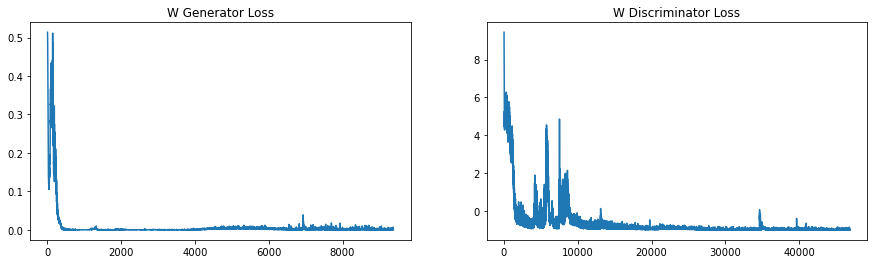

In [24]:
fig = plt.figure(figsize=(15, 4))
columns = 2
rows = 1
counter = 0
for losses, titles in zip([w_g_losses, w_d_losses],["W Generator Loss", "W Discriminator Loss"]):
    fig.add_subplot(rows, columns, counter+1)
    plt.plot(losses)
    plt.title(titles)
    counter += 1
plt.show()

## Plot 25 samples generated using the WGAN 

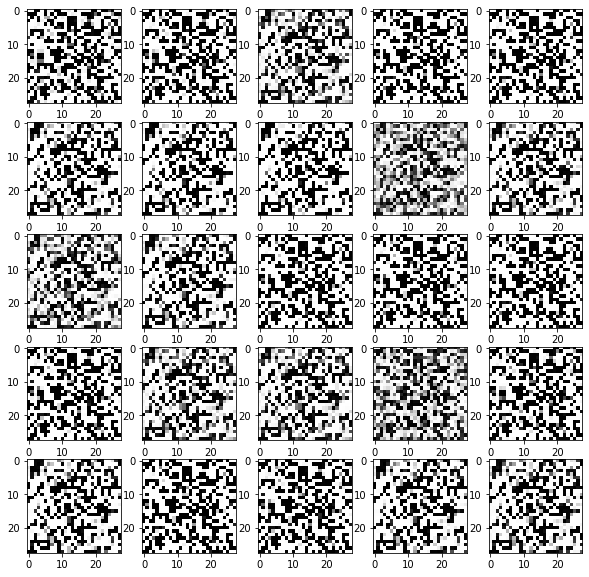

In [25]:
n = 25
z = torch.FloatTensor(n, latent_dim).normal_()
z = z.cuda()
sampled = w_generator(z)

fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
counter = 0
for img in sampled:
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    counter += 1
plt.show()

## (a) Calculate a marginal distribution, again (forWGAN), and create a bar-plot.

In [29]:
noise = torch.FloatTensor(100, latent_dim).normal_()
generated_imgs = w_generator(noise.cuda())

WGAN_labels = [] 
for im in generated_imgs:
    logps = model(im.reshape([-1,784]))
    ps = torch.exp(logps).cpu().detach()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    WGAN_labels.append(pred_label)

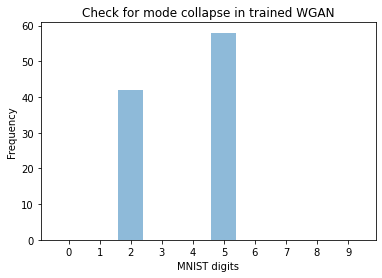

In [30]:
objects = list(range(10))
y_pos = np.arange(len(objects))
counts = [WGAN_labels.count(c) for c in range(10)]

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Check for mode collapse in trained WGAN')
plt.xlabel('MNIST digits')
plt.ylabel('Frequency')

plt.show()

# Conditional GAN

In [57]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [58]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, n_labels):
        super(ConditionalGenerator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_labels, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, c):
        c = idx2onehot(c, n=10)
        z = torch.cat((z, c), dim=-1)
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [59]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_labels):
        super(ConditionalDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + n_labels, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, c):
        img_flat = img.view(img.size(0), -1)
        c = idx2onehot(c, n=10)
        x = torch.cat((img_flat, c), dim=-1)
        validity = self.model(x)

        return validity

In [60]:
def CGAN_train_loop(
    generator: nn.Module, 
    discriminator: nn.Module, 
    g_optim: Optimizer, 
    d_optim: Optimizer,
    latent_dim,
    max_iter=100,
    cuda=True
    ):
    if cuda:
        generator, discriminator = generator.cuda(), discriminator.cuda()
    criterion = nn.BCELoss()
    g_losses, d_losses = [], []
    for epoch in range(max_iter):
        for i, (imgs, labels) in enumerate(dataloader):
            # Configure input
            real_imgs = imgs
            batch_size_internal = real_imgs.shape[0]
            # Adversarial ground truths
            # We use the Cross Entropy (CE) loss. So we need labels:
            ones_labels = torch.ones([batch_size_internal,1])
            zeros_labels = torch.zeros([batch_size_internal,1])
            # Sample noise as generator input
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_() # sample z from a standard gaussian
            gen_labels = torch.randint(0, 10, (batch_size_internal, 1))
            
            if cuda:
                real_imgs, labels = real_imgs.cuda(), labels.cuda()
                z = z.cuda()
                ones_labels, zeros_labels = ones_labels.cuda(), zeros_labels.cuda()
                gen_labels = gen_labels.cuda()
            
            # -----------------
            #  Train Generator
            # -----------------
            generator.train()
            discriminator.eval()
            g_optim.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)# create generated images

            # Loss measures generator's ability to fool the discriminator
            g_loss = criterion(discriminator(gen_imgs, gen_labels), ones_labels)

            g_loss.backward()
            g_optim.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            generator.eval()
            discriminator.train()
            d_optim.zero_grad()
            
            # Sample noise as generator input
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_() # sample z from a standard gaussian
            if cuda:
                z = z.cuda()
            #gen_imgs = generator(z, labels)
            # Measure discriminator's ability to classify real from generated samples
            real_loss = criterion(discriminator(real_imgs, labels), ones_labels)
            fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), zeros_labels)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            d_optim.step()
            
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            
            if i%50 == 0:
                  print(
                  "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %.6f] [G loss: %.6f]"
                  % (epoch+1, max_iter, i, len(dataloader), d_loss.item(), g_loss.item()), end='\r'
            )

            batches_done = epoch * len(dataloader) + i
    #         if batches_done % sample_interval == 0:
    #             # You can also safe samples in your drive & maybe save your network as well
    #             save_image(gen_imgs.data[:25], "images/GAN-%d.png" % batches_done, nrow=5, normalize=True)
    print()
    return g_losses, d_losses

In [61]:
n_labels = 10

# Initialize generator and discriminator
cond_generator = ConditionalGenerator(latent_dim, n_labels)
cond_discriminator = ConditionalDiscriminator(n_labels)

# Optimizers
cond_g_optim = torch.optim.Adam(cond_generator.parameters(), lr=lr, betas=(b1, b2))
cond_d_optim = torch.optim.Adam(cond_discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [62]:
cond_g_losses, cond_d_losses = CGAN_train_loop(cond_generator, cond_discriminator, cond_g_optim, cond_d_optim, 
                                max_iter=20, latent_dim=latent_dim, cuda=True)

[Epoch 20/20] [Batch 900/938] [D loss: 0.400161] [G loss: 1.490704]


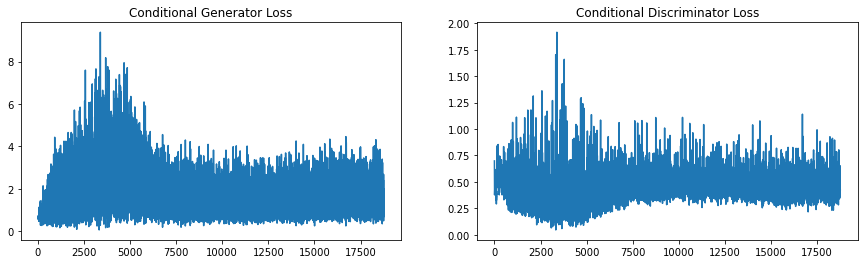

In [63]:
fig = plt.figure(figsize=(15, 4))
columns = 2
rows = 1
counter = 0
for losses, titles in zip([cond_g_losses, cond_d_losses],["Conditional Generator Loss", "Conditional Discriminator Loss"]):
    fig.add_subplot(rows, columns, counter+1)
    plt.plot(losses)
    plt.title(titles)
    counter += 1
plt.show()

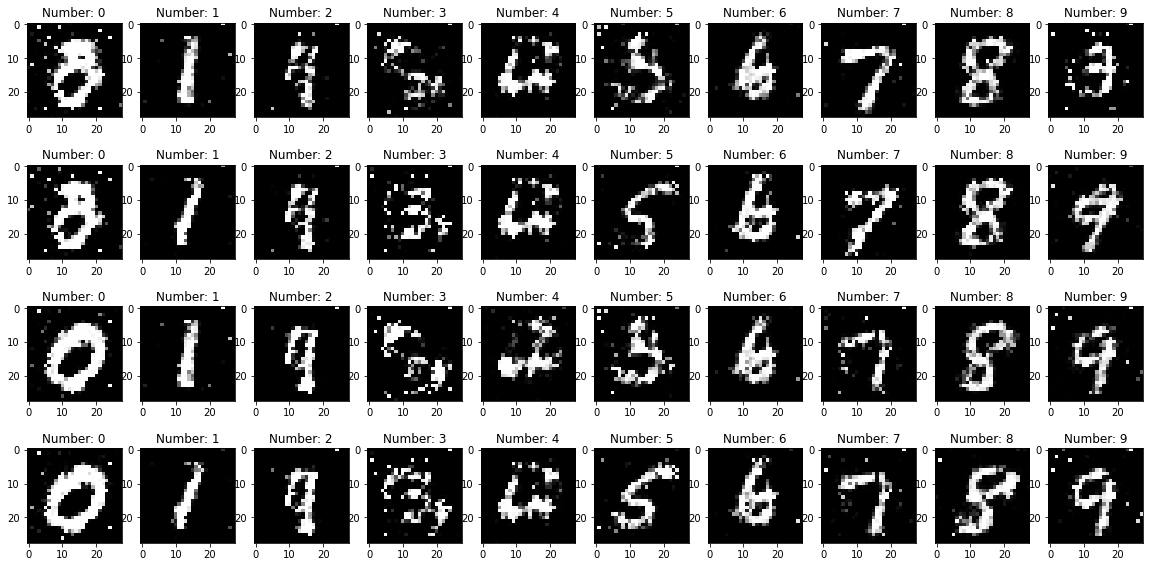

In [64]:
fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 4
counter = 0
z = torch.FloatTensor(40, latent_dim).normal_()
z = z.cuda()
labels_block = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]*4).cuda()
img_block = cond_generator(z, labels_block)
for img, lab in zip(img_block, labels_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Number: {}".format(lab))
    counter += 1
plt.show()

In [171]:
labels_block = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]*100).cuda()
noise = torch.FloatTensor(1000, latent_dim).normal_()
cond_generated_imgs = cond_generator(noise.cuda(), labels_block)

CGAN_labels = [] 
for im in cond_generated_imgs:
    logps = model(im.reshape([-1,784]))
    ps = torch.exp(logps).cpu().detach()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    CGAN_labels.append(pred_label)

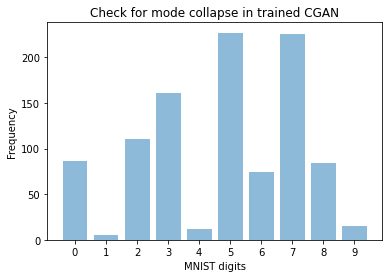

In [172]:
objects = list(range(10))
y_pos = np.arange(len(objects))
counts = [CGAN_labels.count(c) for c in range(10)]

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Check for mode collapse in trained CGAN')
plt.xlabel('MNIST digits')
plt.ylabel('Frequency')

plt.show()